In this notebook, I'm going to use the Fanduel Table I scraped and cleaned in the "Import_and_Clean_FanDuel_NoStats" notebook to see what fun facts we can find about how players did compared to their fanduel price this year. While my data will come from a csv version of my cleaned data, the original data come from RotoGuru1.com

My goal is to see if there are any players who significantly out performed their average price, and if there are any common trends someone can look for to see if certain positions may be cheaper and still provide a high level of output

In [1]:
#pulling in all the necessary python libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from tabulate import tabulate
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

In [2]:
#create frame from saved csv of table I scraped and cleaned from RotoGuru1
tight_frame = pd.read_csv('tight_frame.csv')
#rename columns
tight_frame.columns = ['Row','Date','Position','Name','Fanduel_Points','Fanduel_Price','Team','Minutes_Played','Home_or_Away','Opponent']
tight_frame.dtypes

Row                 int64
Date               object
Position           object
Name               object
Fanduel_Points    float64
Fanduel_Price     float64
Team               object
Minutes_Played    float64
Home_or_Away       object
Opponent           object
dtype: object

First, I want to add a column that would calculate the expected number of points for a player to score based on their price for each player.<br>
Surprisingly, I couldn't find anything letting me know how fanduel calculates price, even though they have a "Value" section after games that lets you know how well a player did based on a multiple of their expected points. <br><br>
For example, if Gary Harris costs 5700 and scores 27.7 points, Fanduel will tell you that he scored 4.9 times his expected total. If Nikola Jokic costs 10200 and scores 71.9, FanDuel will tell you that he scored 7.0x his expected value. If monte Morris costs 4600 and scores 5.5, he is shown as having earned 1.2x his value.

In general, it seems like the equation they are using is round(price/1000,1) = expected value. <br>
For example:<br>
Gary Harris scores 27.7<br>
27.7/4.9 = 5.65<br>
5.65x1000 = 5650<br><br>
Nikola Jokic scores 71.9<br>
71.9/7 = 10.27<br>
10.27x1000 = 102700<br><br>
Monte Morris scores 5.5<br>
5.5/1.2=4.58<br>
4.58x1000 = 4583<br><br>

Online, it seems like there are alot of opinions on how to calculate value, but I'm going to use FanDuel's method since it is consistent and since they're the ones who made the game up in the first place. Then, i'm just going to find the average amount we can expect a player to exceed their value by, since it does seem like this system artificially inflates the "value" of most players.




In [3]:
#creating a column with expected points scored based on price
tight_frame['Expected_Points'] = tight_frame['Fanduel_Price'].apply(lambda x: round (x/1000,1))
#creating a column with Fanduel's value multiplier
tight_frame['Fanduel_multiple'] = (tight_frame['Fanduel_Points']/tight_frame['Expected_Points'])


Now I'm going to take some time to look at measures of centrality for the value multiple so we can figure out a baseline for what is an expected value multiple. I am going to ignore anyone who scored 0 fanduel points, since that means they were likely hurt, did not play anyway, or played garbage time and might as well not have played. I will not ignore these when looking at specific players, but from a holistic perspective if somebody starts an injured person or benchwarmer then they shouldn't be shocked if that person scores zero points.

In [4]:
#I am making a data frame with most of the scores
#but ignoring zeroes for now since that means someone scored zero points and most likely did not play
no_zeros = tight_frame[tight_frame['Fanduel_multiple'] != 0].reset_index(drop=True)

In [5]:
#I discovered that my data cleaning had pulled information from both the 2018-2019 season and from the playoffs,
#which I do not want, so I'm pulling those out here
no_zeros['Date'] = pd.to_datetime(no_zeros['Date'])
#setting dates for Oct 22 2019 and March 10 2020 which is when the season began and then when the season shut down due to COVID
start_date = '10-22-2019'
end_date = '3-10-2020'
#creating filtered column of those dates
no_zeros['mask'] = (no_zeros['Date'] >= start_date) & (no_zeros['Date'] <= end_date)

In [6]:
#now I'm filtering for dates in this season
multiples = no_zeros[no_zeros['mask'] != False].reset_index(drop=True)

In [7]:
#deleting extra columns
del multiples['mask']

In [9]:
#saving this frame as a csv
multiples.to_csv('multiples.csv')

In [10]:
#Taking some measures of centrality here
average_multiple = multiples.mean()
median_multiple = multiples.median()
std_multiple = multiples.std()
print('Averages for NBA Players:')
print(average_multiple)
print('Medians for NBA Players:')
print(median_multiple)
print('Standard Deviations for NBA Players')
print(std_multiple)

<ipython-input-10-20abe372250d>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  average_multiple = multiples.mean()


Averages for NBA Players:
Row                 40038.120535
Fanduel_Points         21.956097
Fanduel_Price        5027.090251
Minutes_Played         23.422822
Expected_Points         5.027090
Fanduel_multiple        4.227806
dtype: float64
Medians for NBA Players:
Row                 40008.500000
Fanduel_Points         20.000000
Fanduel_Price        4300.000000
Minutes_Played         24.133333
Expected_Points         4.300000
Fanduel_multiple        4.171429
dtype: float64
Standard Deviations for NBA Players
Row                 9196.869849
Fanduel_Points        14.144547
Fanduel_Price       1852.314544
Minutes_Played         9.783340
Expected_Points        1.852315
Fanduel_multiple       2.209532
dtype: float64


<ipython-input-10-20abe372250d>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  median_multiple = multiples.median()


Immediate thoughts: <br>
The average/median player scores roughly 4.2 times their value according to how fanduel does their math<br>
<br>
The mean and median for points being around 20 is higher than I expected. 

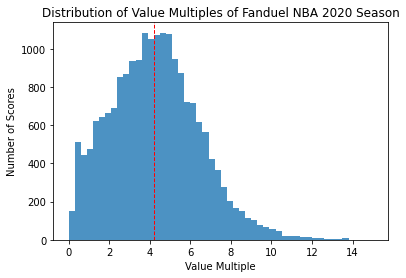

In [11]:
#making a histogram to see the spread of the data
ax=plt.subplot()
plt.hist(multiples['Fanduel_multiple'],bins = 50,range=[0,15],alpha=.8)
#adding the mean
plt.axvline(multiples['Fanduel_multiple'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Value Multiple')
plt.ylabel('Number of Scores')
plt.title('Distribution of Value Multiples of Fanduel NBA 2020 Season')
plt.show()

Now that I have a rough idea of the spread of the data, I want to add some more columns to my dataframe.<br>
I'm going to add fanduel points per minute to see who was more efficient with their time.<br>

In [12]:
#add column with Fanduel points per minute
multiples['PPM'] = multiples['Fanduel_Points']/multiples['Minutes_Played']


Now I'm going to do some general group calculations for players to see who had the highest value relative to their price over the course of the season. I'm going to start by getting some aggregates for players

In [13]:
#create series with average PPM by player
#calculates average Fanduel points per minute for a player
player_ppm = multiples.groupby(['Name']).PPM.mean()
#calculates average Fanduel value multiple for a player
player_multiple = multiples.groupby(['Name']).Fanduel_multiple.mean()
#calculates average fanduel points scored for a player
player_points = multiples.groupby(['Name']).Fanduel_Points.mean()
#calculates typical number of minutes per player by median and mean, along with their sum minutes played
player_minutes_mean = multiples.groupby(['Name']).Minutes_Played.mean()
player_minutes_median = multiples.groupby(['Name']).Minutes_Played.median()
player_minutes_total= multiples.groupby(['Name']).Minutes_Played.sum()
#calculates average and median player price
player_price_mean = multiples.groupby(['Name']).Fanduel_Price.mean()
player_price_median = multiples.groupby(['Name']).Fanduel_Price.median()

#creates dataframe with these aggregate functions
player_table = pd.concat([player_ppm,player_multiple,\
                        player_minutes_mean,\
                        player_minutes_total,player_price_mean]\
                       ,axis=1)
#renames columns
player_table.columns = ['PPM','Average_Value_Multiple','Average_Minutes','Total_Minutes','Average_Price']
#this table contains 508 nba players, many of whom played sparingly.
#I'm going to remove many of them from my final table, but if you want them all this is the frame you want.


In [14]:
player_table

,PPM,Average_Value_Multiple,Average_Minutes,Total_Minutes,Average_Price
Name,,,,,
"Adams, Steven",1.114019,4.945352,27.416667,1562.750000,6249.122807
"Adebayo, Bam",1.196220,4.851732,33.939063,2172.100000,8456.250000
"Aldridge, LaMarcus",1.112249,4.857802,33.095912,1754.083333,7666.037736
"Alexander-Walker, Nickeil",0.846989,3.337444,13.700450,506.916667,3686.486486
"Allen, Grayson",0.712192,3.391800,16.589444,497.683333,3590.000000
...,...,...,...,...,...
"Young, Thaddeus",0.906338,4.727282,24.853906,1590.650000,4820.312500
"Young, Trae",1.331280,4.800370,34.719672,2117.900000,9877.049180
"Zeller, Cody",1.012610,4.677279,23.127193,1318.250000,5212.280702


In [15]:
#taking some averages on minutes here so I can figure out where to draw the line on removing players
player_minutes_mean = player_table['Total_Minutes'].mean()
player_minutes_median = player_table['Total_Minutes'].median()
player_minutes_std = player_table['Total_Minutes'].std()
print('Average Minutes Played:' + str(player_minutes_mean))
print('Median Minutes Played:' + str(player_minutes_median))
print('Deviation Minutes Played:' + str(player_minutes_std))
#After looking at these, it drives home what I should have already known, which is that many NBA players do not play alot

Average Minutes Played:916.5331692913385
Median Minutes Played:892.9416666666668
Deviation Minutes Played:671.4479690797516


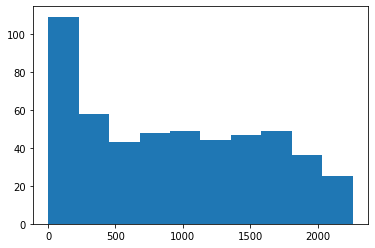

In [16]:
plt.hist(player_table['Total_Minutes'],bins=10)
plt.show()

Now that I have aggregate data for all players, I want to see who is the best. I am going to clean the set here so that players who only played one or two games don't grab all the spots at the top and bottom of my rankings, so I'm going to filter the tables based on minutes.<br>
The average player in the NBA in 2019-2020 played for ~900 minutes. However, looking at the distirbution of the data, it is clear there is a vast group of players who barely played at all. To clean up the table for players who go consistent minutes, I am going to remove all players with an average playing time of less then 800 minutes.<br><br>

I chose 800 minutes because 800 minutes/67 games (the average number of games a team played in 2020 before COVID shutdowns) is 11.94 minutes a game, or just barely under a quarter of a basketball game. I'm not really interested in any players who are on the court for less than that amount of time.

In [17]:
#creating table with players who had over the average number of minutes
players_only = player_table[player_table['Total_Minutes'] >= 800].reset_index()
#this table only has 270 players

Now I'm going to redo the same measures of centrality with our smaller list to confirm if our baselines are the same


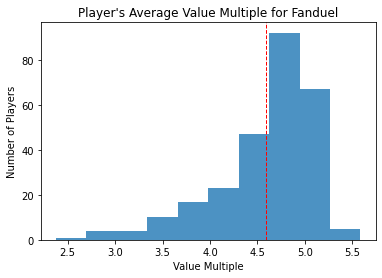

In [18]:
#making a histogram to see the spread of the data
ax=plt.subplot()
plt.hist(players_only['Average_Value_Multiple'],bins = 10,alpha=.8)
#adding the mean
plt.axvline(players_only['Average_Value_Multiple'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Value Multiple')
plt.ylabel('Number of Players')
plt.title("Player's Average Value Multiple for Fanduel")
plt.show()

It looks like the values are left skewed with a strong cluster around 4.5-5. I'd like to be able to normalize this data so we can get a cleaner look at player values.

Now let's sort this to figure out who the best players are by value multiple. It will paint a clearer picture if I normalize the value multiples instead of just eyeballing them.

Since the data doesn't have a normal distribution, I'm not going to use the z-score function. Instead, I will use (x-min)/(max-x) so we can just easily see how close a player's score is to the maximum value for an NBA Fanduel player in a game in 2020.

In [19]:
#Writing function to normlaize a column
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y
#Creating series of normalized Fanduel_values
players_only_norm = normalize(players_only['Average_Value_Multiple'])
#Adding list to our frame as a column
players_only['Norm_Value'] = players_only_norm
#Repeating for Price
players_only_price_norm = normalize(players_only['Average_Price'])
#adding column
players_only['Norm_Price'] = players_only_price_norm
players_only

,Name,PPM,Average_Value_Multiple,Average_Minutes,Total_Minutes,Average_Price,Norm_Value,Norm_Price
0,"Adams, Steven",1.114019,4.945352,27.416667,1562.750000,6249.122807,0.800638,0.327433
1,"Adebayo, Bam",1.196220,4.851732,33.939063,2172.100000,8456.250000,0.771450,0.591333
2,"Aldridge, LaMarcus",1.112249,4.857802,33.095912,1754.083333,7666.037736,0.773343,0.496849
3,"Allen, Jarrett",1.090218,4.836833,25.739583,1647.333333,5900.000000,0.766805,0.285689
4,"Anderson, Kyle",0.897707,4.312963,19.500000,1131.000000,4018.965517,0.603481,0.060779
...,...,...,...,...,...,...,...,...
265,"Wright, Delon",0.931005,4.591777,22.057258,1367.550000,4585.483871,0.690405,0.128516
266,"Young, Thaddeus",0.906338,4.727282,24.853906,1590.650000,4820.312500,0.732651,0.156594
267,"Young, Trae",1.331280,4.800370,34.719672,2117.900000,9877.049180,0.755437,0.761214
268,"Zeller, Cody",1.012610,4.677279,23.127193,1318.250000,5212.280702,0.717062,0.203461


Now, I want to take a look at how players stack up based on the ratio of their average fanduel value vs the baseline

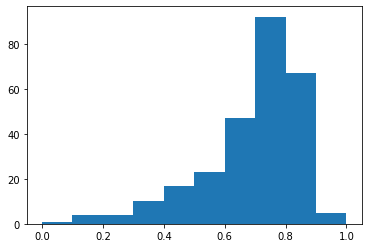

In [20]:
#confirming our distirbution still has roughly the same shape 
plt.hist(players_only['Norm_Value'],bins=10)
plt.show()

Now that we're comparing 0-1 instead of deciphering numbers on the value scale, it should make things a little clearer on player value since we have them ranked.

In [21]:
#creating sorted table by Norm first, then tiebreaking with average minutes to give credit to players who get more floor time
player_norm_ranks = players_only.sort_values(['Norm_Value','Average_Minutes'],ascending=False).reset_index(drop=True)
player_norm_ranks

,Name,PPM,Average_Value_Multiple,Average_Minutes,Total_Minutes,Average_Price,Norm_Value,Norm_Price
0,"Powell, Norman",0.918237,5.584814,29.477519,1267.533333,4906.976744,1.000000,0.166956
1,"Smart, Marcus",0.912724,5.381304,32.466352,1720.716667,5643.396226,0.936553,0.255008
2,"Brown, Bruce",0.813155,5.277332,28.172414,1634.000000,4539.655172,0.904138,0.123037
3,"Theis, Daniel",1.022601,5.274462,23.831897,1382.250000,4653.448276,0.903243,0.136643
4,"LeVert, Caris",1.014758,5.269326,29.005983,1131.233333,5741.025641,0.901642,0.266681
...,...,...,...,...,...,...,...,...
265,"Carter, Vince",0.704235,3.012039,14.704310,852.850000,3568.965517,0.197897,0.006974
266,"Graham, Treveon",0.584759,2.986580,18.013333,900.666667,3610.000000,0.189960,0.011880
267,"Williams, Grant",0.645942,2.898382,15.637366,969.516667,3562.903226,0.162463,0.006249
268,"Ferguson, Terrance",0.394561,2.777196,24.473759,1150.266667,3510.638298,0.124681,0.000000


A brief glance at this list indicates that sixth men are gonna give you the best bang for your buck. I feel like there's going to be high variance with these guys though, since odds are good alot of their best nights come when starters are resting.

I'd want to use the base table with scores by date to find who consistently beat expectations night to night. That's going to be a different notebook.

In [22]:
#Saving as csv
players_only.to_csv('player_totals.csv')

In [23]:
#Cleaning up the original multiples table to only include these players I looked at in the above chart
players = list(players_only['Name'])
players_table = multiples[multiples['Name'].isin(players)].reset_index(drop=True)
#saving this as a csv
players_table.to_csv('multiples.csv')

In addiiton to my work here, I went ahead and used Tableau to make some visualizations on player value, as well as value per position. I also was able to show player value per date. <br><br>

You can see all of my visualizations here: https://public.tableau.com/profile/clinton.sorrel#!/?newProfile=&activeTab=0